In [1]:
pip install sshtunnel

Note: you may need to restart the kernel to use updated packages.


## Purpose:
* Demonstrate how to:
    * Get metadata database
    * See dataset sources
    * See current datasets
    * Get attribute look-up table for a specific dataset
    * Get data of a specific dataset from bigdata table
    * Example of how to use data to create graph

#### Imports / Settings / Connect to Mongodb

In [57]:
#  ---------------
#   I M P O R T S 
#  ---------------
from sshtunnel import SSHTunnelForwarder
import pymongo
import pprint

import pandas as pd

#  ------------------
#    S E T T I N G S
#  ------------------

pd.set_option('max_colwidth', 100)


#  ----------------
#   M O N G O D B 
#  ----------------


MONGO_HOST = "128.206.117.150"
MONGO_USER = "haithcoatt"
MONGO_PASS = "Ke11ieJean"

server = SSHTunnelForwarder(
    MONGO_HOST,
    ssh_username=MONGO_USER,
    ssh_password=MONGO_PASS,
    remote_bind_address=('127.0.0.1', 27017)
)

server.start()
client = pymongo.MongoClient('127.0.0.1', server.local_bind_port) # server.local_bind_port is assigned local port


## Get metadata database

In [58]:
db = client.metadata

#### What Collections are in metadata database?**

In [59]:
db.collection_names()

['attributes', 'metadata', 'bigdata', 'sources', 'datasets']

## Create dataframes for sources and metadata collections
* The **sources collection** contains the names of all the sources that have datasets in the the bigdata collection. 
* The **metadata collection** contains information about each dataset and each dataset object has an "attributes" object that is used as the look-up table for each attribute.
   

In [60]:
sources = pd.DataFrame(list(db.sources.find()))
metadata= pd.DataFrame(list(db.metadata.find()))

## What are the data sources?

In [8]:
sources[['originator','originator_prefix']]

,originator,originator_prefix
0,USA Facts,USA_FACTS
1,United States Deparment of Agriculture Economic Research Service,USDA
2,Harvard Global Health Institute,HGHI


## What data sets are available?

In [11]:
metadata[['originator_id','dataset_name','originator']]

,originator_id,dataset_name,originator
0,USDA_02_01,Food Environment Atlas,USDA
1,USDA_01_01,Food Access Research Atlas,USDA
2,USDA_03_01,Atlas of Rural and Small-Town America,USDA
3,USA_FACTS_01_01,Confirmed Covid 19 Cases in US by State and County (Jan-July 21 2020),USA_FACTS
4,USA_FACTS_02_01,Confirmed Covid 19 Deaths in US by State and County (Jan-July 21 2020),USA_FACTS
5,HGHI_02_01,Harcard Global Health Institute COVID-19 Hospital Referral Regions (HRR) 2020,HGHI
6,HGHI_01_01,Harvard Global Health Institute COVID-19 Hospital Capacity Estimates 2020,HGHI


## What are the attributes for a specific dataset?

* The attr_label is the name of the attribute in the bigdata collection.

In [26]:
# Use the originator_id of the dataset to get attributes object
org_id="HGHI_01_01"

# Create attributes dataframe
attributes=pd.DataFrame(list(metadata.loc[metadata.originator_id==org_id].attributes)[0])

#displaying first 5 rows of attributes table
attributes.head(5)

,_id,originator_id,start_date,end_date,update_freq,iso_key,iso_key_add,attr_label,attr_orig,attr_desc,attr_data_type,scale,positional_accuracy,spatial_rep,datum,coordinate_system,entity_type
0,5f3c938b85deac56aac95549,HGHI_01_01,2020,2020,NA,3,3b,HGHI_01_01_01,State,State,SQL_VARCHAR,NA,NA,POLYGON,NA,NA,STATE
1,5f3c938b85deac56aac9554e,HGHI_01_01,2020,2020,NA,9,NA,HGHI_01_01_02,20_total_hospital_beds,20% Hospital Capacity- Total Hospital Beds,SQL_INT,NA,NA,POLYGON,NA,NA,STATE
2,5f3c938b85deac56aac9554f,HGHI_01_01,2020,2020,NA,9,NA,HGHI_01_01_03,20_total_icu_beds,20% Hospital Capacity- Total ICU Beds,SQL_INT,NA,NA,POLYGON,NA,NA,STATE
3,5f3c938b85deac56aac95550,HGHI_01_01,2020,2020,NA,9,NA,HGHI_01_01_04,20_potentially_avail_icul_beds,20% Hospital Capacity- Potentially Available ICU Beds*,SQL_INT,NA,NA,POLYGON,NA,NA,STATE
4,5f3c938b85deac56aac95551,HGHI_01_01,2020,2020,NA,9,NA,HGHI_01_01_05,20_icu_bed_occ_rate,20% Hospital Capacity- ICU Bed Occupancy Rate,SQL_REAL,NA,NA,POLYGON,NA,NA,STATE


## Get data for specific dataset

* **To pull in all the data for a dataset**, use the mongodb method "find()" to find all objects that contain one of the fields from the dataset (since each dataset will always have an attribute with the name "[originator_id]-01", I would suggest using that field).
* Use the attributes look up table above, to identify what data each column contains

In [28]:
dataset_data=pd.DataFrame(list(db.bigdata.find({"HGHI_02_01_01":{"$ne":None}})))
  
    
#displaying first five rows of data
dataset_data.head(5)

,_id,HGHI_02_01_01,HGHI_02_01_02,HGHI_02_01_03,HGHI_02_01_07,HGHI_02_01_09,HGHI_02_01_04,HGHI_02_01_05,HGHI_02_01_06,HGHI_02_01_08,...,HGHI_02_01_95,HGHI_02_01_98,HGHI_02_01_99,HGHI_02_01_100,HGHI_02_01_101,HGHI_02_01_103,HGHI_02_01_104,HGHI_02_01_102,HGHI_02_01_105,HGHI_02_01_106
0,5f42f6e34b545863438e776d,Abilene TX,980.0,127.0,565.0,772.0,68.0,98.0,226444.0,50412.0,...,4.27,3.29,209.0,3.07,2.13,1.65,136.0,2.00,1.39,1.07
1,5f42f6e34b545863438e776e,Akron OH,1358.0,186.0,518.0,938.0,94.0,140.0,547990.0,111042.0,...,7.09,5.33,496.0,5.28,3.54,2.67,323.0,3.44,2.31,1.74
2,5f42f6e34b545863438e776f,Alameda County CA,2695.0,293.0,665.0,1680.0,139.0,216.0,1310189.0,214991.0,...,10.56,7.78,1140.0,8.20,5.28,3.89,743.0,5.35,3.44,2.54
3,5f42f6e34b545863438e7770,Albany GA,704.0,60.0,221.0,462.0,27.0,43.0,157143.0,30466.0,...,6.56,4.70,141.0,5.22,3.28,2.35,92.0,3.41,2.14,1.53
4,5f42f6e34b545863438e7771,Albany NY,4804.0,425.0,1579.0,3191.0,193.0,309.0,1477723.0,318695.0,...,8.77,6.37,1355.0,7.02,4.39,3.19,883.0,4.58,2.86,2.08


## Use data to create visual

Text(0, 0.5, 'Total Hospital Beds')

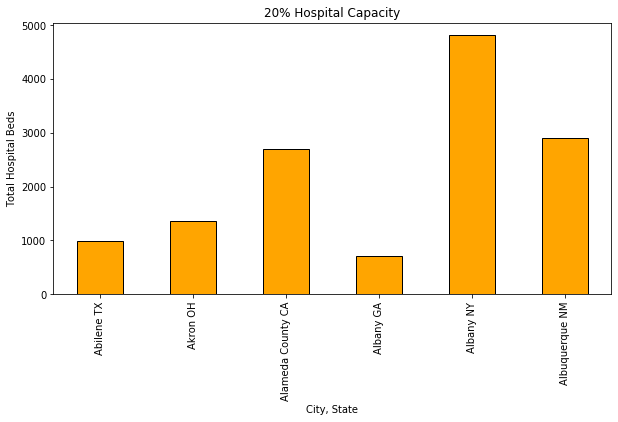

In [55]:


ax= dataset_data.loc[0:5].plot.bar(x='HGHI_02_01_01',y="HGHI_02_01_02", title="20% Hospital Capacity", figsize=(10,5),color="orange",ec="black")
ax.get_legend().remove()
ax.set_xlabel("City, State")
ax.set_ylabel("Total Hospital Beds")